# **VICO Spring Week 3 Practical: introduction to colour correction, radiometry and photometry**

Like last Friday, today we'll be using numpy, matplotlib and OpenCV. The following block should look familiar, since it is essentially the same as last week. It imports what needed and downloads some images to the session storage.

In [1]:
# Download the image
!wget https://www.dropbox.com/s/68arqqi52zb9f97/IMG_FG_BL.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/ltgfaddkuaoh23l/IMG_DF_BL.tiff




--2023-01-27 13:16:21--  https://www.dropbox.com/s/68arqqi52zb9f97/IMG_FG_BL.tiff
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/68arqqi52zb9f97/IMG_FG_BL.tiff [following]
--2023-01-27 13:16:21--  https://www.dropbox.com/s/raw/68arqqi52zb9f97/IMG_FG_BL.tiff
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11a7477fab96f49150213fa205.dl.dropboxusercontent.com/cd/0/inline/B1UdGAdE719kBcb1SWqohHEDogctLbXDfq35H5v0YonjDqA05iE3YqAtbcY4ECKrKTNXZqGEJlKg4-AJ3NJAJqjGBI3wL8pINv04CcOVSUkpCrrpvg_7XPCTbKagzTwtKVo9uGVNUh7nkrF6eCY_9OC6H3NkTudOg2JwGkwPik0q6Q/file# [following]
--2023-01-27 13:16:22--  https://uc11a7477fab96f49150213fa205.dl.dropboxusercontent.com/cd/0/inline/B1UdGAdE719kBcb1SWqohHEDogctLbXDfq35H5v0YonjDqA05iE3YqAtbcY4ECKrKTNXZqGEJlKg4-AJ3NJAJqjGBI3wL8pINv04

In [3]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

Let's load the two images. One is the photograph of a portion of a colour checker chart, the other one is a dark frame.


Image datatype: uint16
Image dimensions: (3012, 2012)


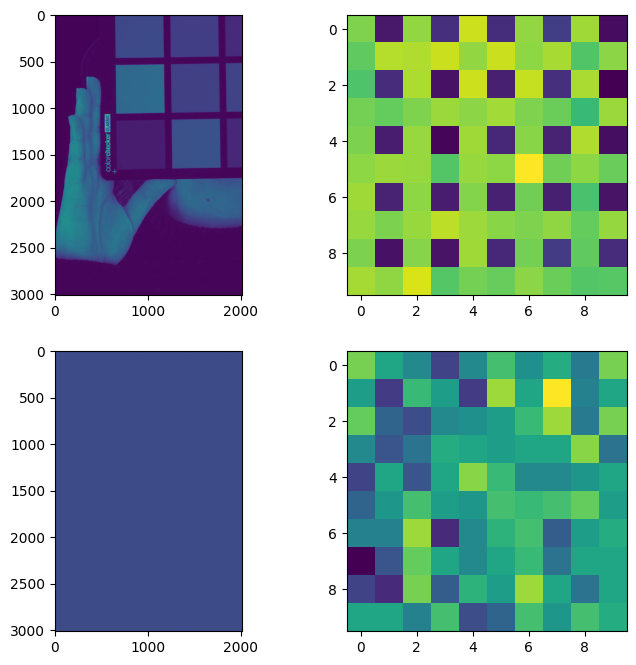

In [9]:
img = cv2.imread("IMG_FG_BL.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame = cv2.imread("IMG_DF_BL.tiff", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# Both images in bayer format, so uint16 single channel
print('Image datatype:',img.dtype)
print('Image dimensions:',img.shape)

fig=plt.figure(figsize=(8, 8)) 
fig.add_subplot(2,2,1) 
plt.imshow(img) 
fig.add_subplot(2,2,2) 
plt.imshow(img[800:810,900:910]) 
fig.add_subplot(2,2,3) 
plt.imshow(dark_frame) 
fig.add_subplot(2,2,4) 
plt.imshow(dark_frame) 
plt.imshow(dark_frame[800:810,900:910]) 
plt.show()

If we look at a small homogeneous area of the image (somewhere within a patch of the colour checker chart), we can see the bayer pattern. If we do the same with the dark frame (photograph taken with the lens cap on) we just see random pixels value. That's not surprising, given that the dark frame provide us with a way to estimate sensor noise, as well as the sensor black level. 

In [10]:
black_level = round(np.mean(dark_frame))
print('The estimated black level is: ', black_level )

The estimated black level is:  2048


Let's subtract the black level from the image and apply a debayering algorithm from the openCV library and display the result. We need to know the bayer pattern to do so! In this case we will use the constant *cv2.COLOR_BAYER_GR2RGB*. Have a look at this link to the the other possible bayer patterns: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


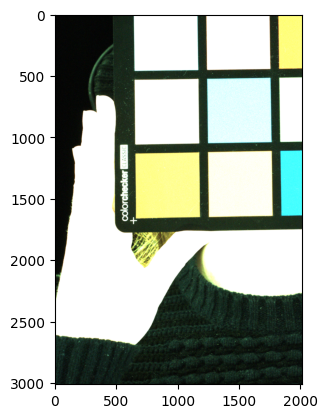

In [11]:

img = cv2.subtract(img, dark_frame)

colour_img = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB)
plt.imshow(colour_img)

We had no issue in visualising the grayscale bayer pattern images. However, since `colour_img` has 3 channels and it is uint16, all the values are clipped to 255, leading to the saturated image above.
To visualise it, we can rescale it to the [0-1] range, accounding for the actual range of values acquired by the camera (that is, between the black level and the max value - in this case `2**16-1`) and then gamma correct the image. Let's use gamma 2.2. 

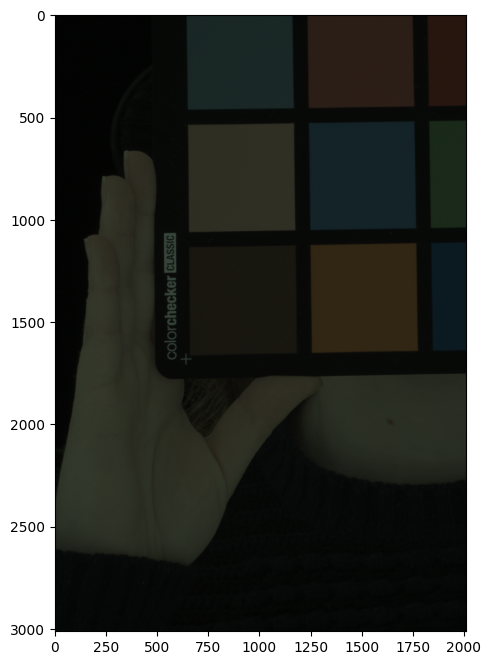

In [13]:

colour_img_display = colour_img.astype(np.float32)/((2**16-1)-black_level) 

fig=plt.figure(figsize=(8, 8)) 
plt.imshow(np.power(colour_img_display,1/2.2))


Let's perform the debayering using a different algorithm, edge-aware this time.

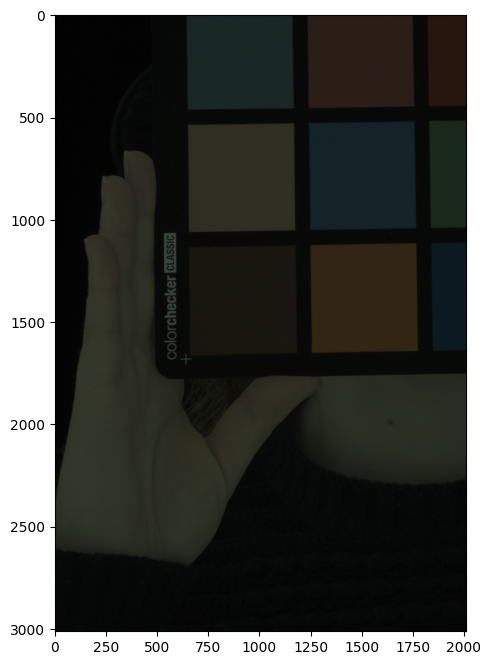

In [14]:
colour_img_EA = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB_EA)
colour_img_EA_display = colour_img_EA.astype(np.float32)/((2**16-1)-black_level) 

fig=plt.figure(figsize=(8, 8)) 
plt.imshow(np.power(colour_img_EA_display,1/2.2))



The difference is not immediately noticeable, at least at this scale. Let's compute a difference map between the output of the two different debayering algorithms. In particular, we will work on a greyscale version of the images,computed according to the formula reported at this link: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html. Refrain from using the term "luminance": the images are still in camera colour space and the equation is rather approximated.

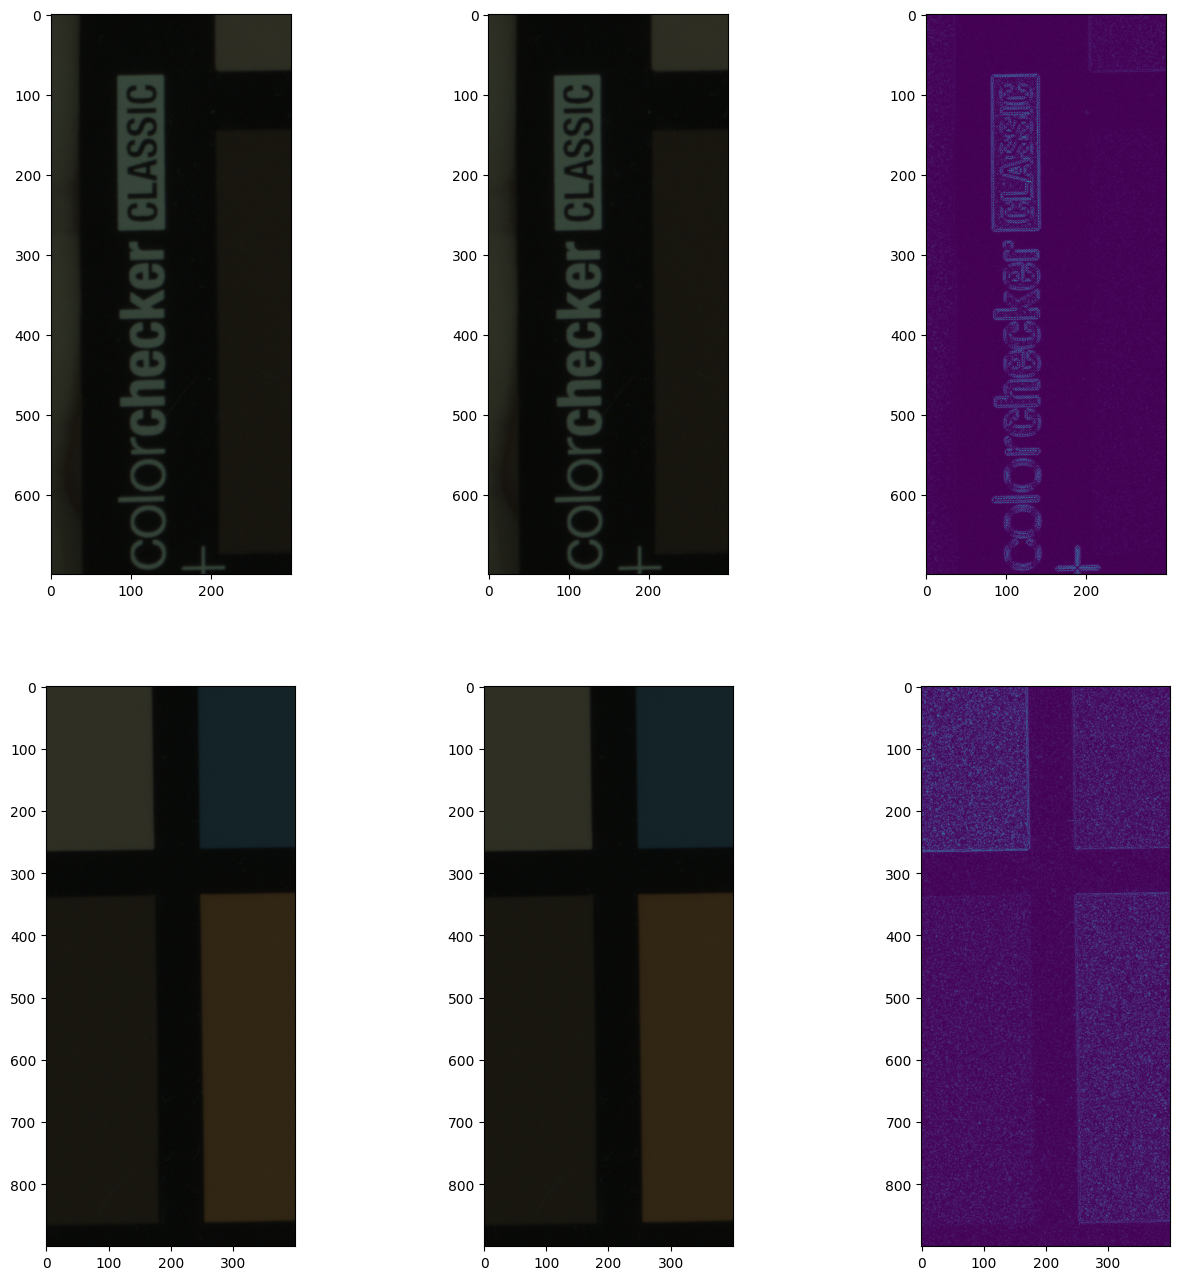

In [16]:
grey_img_EA = cv2.cvtColor(colour_img_EA, cv2.COLOR_RGB2GRAY) 
grey_img_EA = grey_img_EA.astype(np.float32)/((2**16-1)-black_level) 

grey_img = cv2.cvtColor(colour_img, cv2.COLOR_RGB2GRAY)
grey_img = grey_img.astype(np.float32)/((2**16-1)-black_level) 

diff = abs(grey_img - grey_img_EA);



detail_01_colour = colour_img_display[990:1690,450:750]
detail_01_colour_EA = colour_img_EA_display[990:1690,450:750]

detail_02_colour = colour_img_display[790:1690,1000:1400]
detail_02_colour_EA = colour_img_EA_display[790:1690,1000:1400]



fig=plt.figure(figsize=(16, 16)) 
fig.add_subplot(2,3,1) 
plt.imshow(np.power(detail_01_colour,1/2.2)) 
fig.add_subplot(2,3,2) 
plt.imshow(np.power(detail_01_colour_EA,1/2.2)); 
fig.add_subplot(2,3,3) 
plt.imshow(diff[990:1690,450:750]);
fig.add_subplot(2,3,4)
plt.imshow(np.power(detail_02_colour,1/2.2));
fig.add_subplot(2,3,5)
plt.imshow(np.power(detail_02_colour_EA,1/2.2));
fig.add_subplot(2,3,6)
plt.imshow(diff[790:1690,1000:1400])
plt.show()

Unsurprisingly, the main differences are visible around strong edges in the image (as well as in noisy areas). The image `colour_img_display` (as well as `colour_img_EA_display`) are in linear camera RGB and are ready for colour correction.

# Task 1: Debayering

---
Load the two images below, taken with a different camera with respect to the one used in the previous example (this camera might use a different bayer pattern). Correct for the dark frame and debayer the resulting image, then visualize the result.

Hint: if the colours look "weird", then you might have selected the wrong bayer pattern for the camera!


In [17]:
# Download the image
!wget https://www.dropbox.com/s/5qr8rcfcpq4iyhr/img.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/6l87ggjr1hzahw7/dark_frame.tiff

--2023-01-27 13:21:28--  https://www.dropbox.com/s/5qr8rcfcpq4iyhr/img.tiff
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5qr8rcfcpq4iyhr/img.tiff [following]
--2023-01-27 13:21:28--  https://www.dropbox.com/s/raw/5qr8rcfcpq4iyhr/img.tiff
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb73c260e108322ec33928f6a57.dl.dropboxusercontent.com/cd/0/inline/B1XszrELNhZxR6q-AfeneyHOs1wrcCicTyTPDpFruBdSxfcKLjahG4C-vJJhIESW85wdgK6C9deJxZFSOtm0DFRLVY0rscXhutpAU04S7zyf4Sj_IxktiwXmN1lcuKOVcbqcoZs70l1WOevz8wp9adkcqA4Tcx3FX9ab_7kjX1tj6A/file# [following]
--2023-01-27 13:21:29--  https://ucb73c260e108322ec33928f6a57.dl.dropboxusercontent.com/cd/0/inline/B1XszrELNhZxR6q-AfeneyHOs1wrcCicTyTPDpFruBdSxfcKLjahG4C-vJJhIESW85wdgK6C9deJxZFSOtm0DFRLVY0rscXhutpAU04S7zyf4Sj_Ixktiw

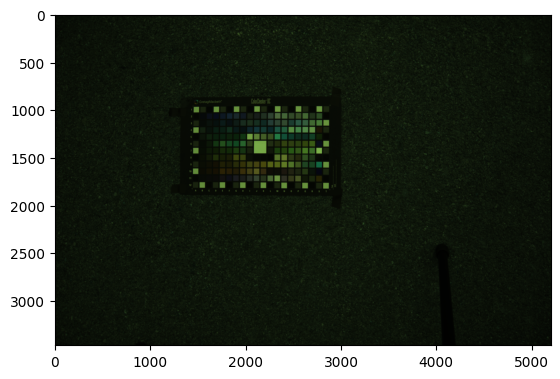

In [57]:
img = cv2.imread('img.tiff', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

img = cv2.subtract(img, dark_frame) # Remove noise
img = cv2.cvtColor(img, cv2.COLOR_BAYER_BGGR2RGB)

img = img.astype(np.float32)/((2**14-1)-black_level) # normalize to between one and zero
# plt.imshow(img[1580:1600, 1580:1600]);
plt.imshow(img);
# plt.axis('off');

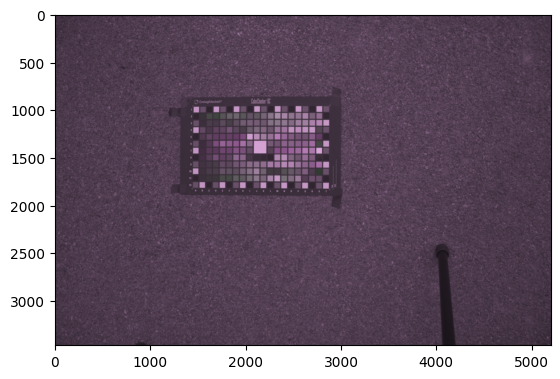

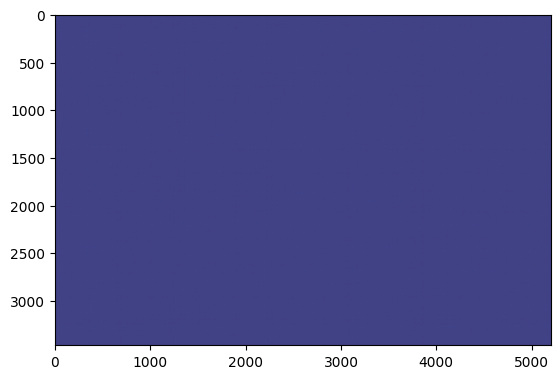

In [86]:
img = cv2.imread('img.tiff', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame = cv2.imread('dark_frame.tiff', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

img = cv2.subtract(img, dark_frame) # Remove noise


img = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB)

black_level = round(np.mean(dark_frame))
img = img.astype(np.float32)/((2**14-1)-black_level) # normalize to between one and zero
img = np.power(img, 1/2.2)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(dark_frame);
# fig=plt.figure(figsize=(8, 8)) 
# fig.add_subplot(2,2,1) 
# plt.imshow(img) 
# fig.add_subplot(2,2,2) 
# plt.imshow(img[800:810,900:910]) 
# fig.add_subplot(2,2,3) 
# plt.imshow(dark_frame) 
# fig.add_subplot(2,2,4) 
# plt.imshow(dark_frame) 
# plt.imshow(dark_frame[800:810,900:910]) 
# plt.show()

In [58]:
10267, 2**14-1-black_level

(10267, 14335)

# Task 2: colour correction

---
Let's go back to camera used in the first example and this time load the entire image (at half resolution, to avoid running out of memory in Colab).
For this camera, we know the spectral sensitivity. Using the equations seen in the lecture slides, colour correct the image and display the resulting image in simplified sRGB. Compare it with the image before colour correction.
You can find the spectral data required for this task (range 400nm to 700nm, 10nm resulution) at the following links:

*   light spectrum (D65): https://www.dropbox.com/s/qqmaq88oa9z7nx5/light_spectrum.txt

*   spectral reflectances: https://www.dropbox.com/s/3er06l5toig4er6/spectral_reflectances.txt
*   CIE colour matching functions: https://www.dropbox.com/s/zh0t3bqwxx8xknc/CIE_1931_CMFs.txt
*   camera spectral sensitivity: https://www.dropbox.com/s/y6q8vkw5gayohkc/camera_spectral_sensitivity.txt

Suggestion: rescale the simulated camera RGB values such that the max is 0.95. Since we have not accounted for exposure time and other factors, this will (roughly) do. 

At each step, pay attention to out-of-gamut values: negative RGB coordinates, or above 1, need to be clamped!

Before visualising original (debayered) image and colour corrected one, scale their (linear) values by 4: the image was a bit underexposed! 



In [ ]:
!wget https://www.dropbox.com/s/3er06l5toig4er6/spectral_reflectances.txt
!wget https://www.dropbox.com/s/zh0t3bqwxx8xknc/CIE_1931_CMFs.txt
!wget https://www.dropbox.com/s/qqmaq88oa9z7nx5/light_spectrum.txt
!wget https://www.dropbox.com/s/y6q8vkw5gayohkc/camera_spectral_sensitivity.txt

# Download the image
!wget https://www.dropbox.com/s/88ayc2xoi56mb32/IMG_FG_small.tiff

# Download the dark frame
!wget https://www.dropbox.com/s/8r8s2uq7nqth2nf/IMG_DF_small.tiff


In [66]:
spectral_data = {}
for fname in ['spectral_reflectances', 'CIE_1931_CMFs', 'light_spectrum', 'camera_spectral_sensitivity']:
    with open(fname + '.txt') as f:
        data = f.read().split()
        spectral_data[fname] = data

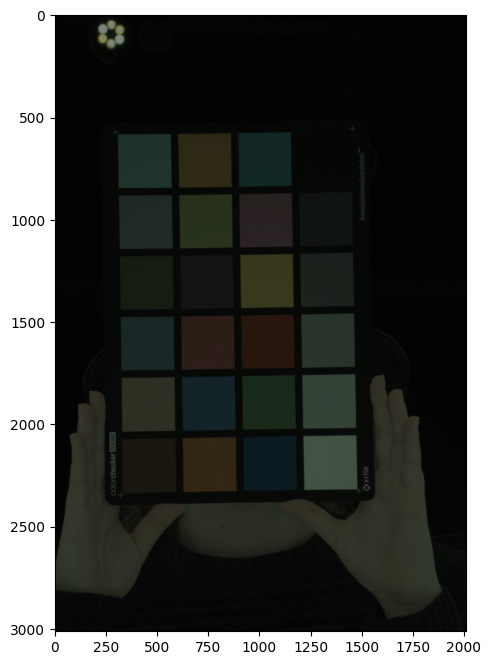

In [87]:
img = cv2.imread('IMG_FG_small.tiff', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
dark_frame = cv2.imread('IMG_DF_small.tiff', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

img = cv2.subtract(img, dark_frame) # Remove noise

colour_img = cv2.cvtColor(img, cv2.COLOR_BAYER_GR2RGB_EA)

black_level = round(np.mean(dark_frame))
display_img = colour_img.astype(np.float32)/((2**16-1)-black_level) 
display_img = np.power(display_img,1/2.2) 
img = display_img

fig=plt.figure(figsize=(8, 8)) 
plt.imshow(img);

###Task 3: white balancing



---


The colour correction has improved the colour appearance. However, the image was acquired under a slighly different lighting than D65 (a bit *warmer*), which we used for our computations, so we now have a reddish colour cast. White balancing techniques are aimed at estimating the illuminant and removing the colour cast. In this way, neutral patches will look as they are supposed to: grey. 
While we have not seen any white balancing technique, we can perform a rough white balancing by scaling the RGB channels in such a way the average RGB value on the white patch are as follows: `[0.9934*avgG    avgG    0.9548*avgG]`, where `avgG` is the average green value in the white patch. If you wonder where these values come from, have a look at the 6th row in the RGB matrix derived from the XYZ tristimulus values, which correspond to the RGB colour appearance of a white patch under D65. 
Note that applying such technique directly to the debayered image, whithout the colour correction step, does not lead to the same results, since the differences between CIE CMFs and camera sensitivities are not accounted for. 
Give it a try! 

In [132]:
# 344982
# (3012, 2012, 3)
# 344982 // 3012 = 144
# img.flatten().max() = 0.5
white_patch_green = img[144][272][1] # Actually the white light but hey
white_patch_green
avgG = img[:, :, 1].mean()
target_white = [0.9934*avgG,    avgG,    0.9548*avgG]
target_white

[0.07798323485851287, 0.078501344, 0.07495308299064636]

###Task 4: Photometry

---

Let's say you can comfortably read a book with an illuminance of 50 lux. If you have a 150 cd light bulb, at what distance does it need to be from the book?